# 第8章: ニューラルネット

[https://nlp100.github.io/ja/ch08.html](https://nlp100.github.io/ja/ch08.html)

第6章で取り組んだニュース記事のカテゴリ分類を題材として，ニューラルネットワークでカテゴリ分類モデルを実装する．なお，この章ではPyTorch, TensorFlow, Chainerなどの機械学習プラットフォームを活用せよ．

## 70. 単語ベクトルの和による特徴量

In [ ]:
import gensim
import numpy as np
import pandas as pd
import spacy
import torch
import tqdm

# global variables
dataset_types = ['train', 'valid', 'test']
label2int = {
    "b": 0,
    "t": 1,
    "e": 2,
    "m": 3
}
Xs, ys = {}, {}
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print('Using {} device'.format(device.type))


def makeDatasetFiles():
    nlp = spacy.load("en_core_web_sm")

    # Word2Vec
    w2v = gensim.models.KeyedVectors.load_word2vec_format(
        '../Chapter7/GoogleNews-vectors-negative300.bin', 
        binary=True)

    for dataset in dataset_types:
        tmp_x, tmp_y = [], []
        tmp_df = pd.read_table('../Chapter6/{:}.txt'.format(dataset))

        for each in tmp_df.itertuples():

            # make X
            tokens = [token for token in nlp(each.TITLE)]
            num_tokens = len(tokens)

            x_i = np.zeros(300)
            for token in tokens:
                try:
                    token_embedding = w2v[str(token)]
                    x_i = np.add(x_i, token_embedding)

                except KeyError:
                    num_tokens -= 1
                    continue

            x_i = np.divide(x_i, num_tokens)
            tmp_x.append(x_i)

            # make y
            tmp_y.append(label2int[each.CATEGORY])
        
        # convert to torch.Tensor
        Xs[dataset] = torch.Tensor([tmp_x]).float()
        ys[dataset] = torch.Tensor([tmp_y]).long()

        # pickle
        torch.save(Xs[dataset], 'X_{:}.pickle'.format(dataset))
        torch.save(ys[dataset], 'y_{:}.pickle'.format(dataset))
    
    return Xs, ys

/usr/local/lib/python3.8/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)
Using cpu device


## 71. 単層ニューラルネットワークによる予測

In [ ]:
# Data load
try:
    for dataset in dataset_types:
        Xs[dataset] = torch.load(
            'X_{:}.pickle'.format(dataset),
            map_location=device)
        ys[dataset] = torch.load(
            'y_{:}.pickle'.format(dataset),
            map_location=device)
except FileNotFoundError:
    Xs, ys = makeDatasetFiles()
    assert Xs != {} and ys != {}

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

# Define network
torch.manual_seed(46)
single_layer_network = nn.Sequential(
    nn.Linear(300, 4)
)

hat_Y, x_i, logits, probs = [], [], [], []
for i in range(4):
    x_i.append(torch.index_select(Xs['train'], dim=1, index=torch.tensor([i])))
    logits.append(single_layer_network(x_i[-1]))
    probs.append(F.softmax(logits[-1], dim=2))
    hat_Y.append(probs[-1].detach())

print('hat_y_1 = {:}'.format(hat_Y[0]))
print('hat_Y = {:}'.format(hat_Y))

hat_y_1 = tensor([[[0.2525, 0.2487, 0.2648, 0.2341]]])
hat_Y = [tensor([[[0.2525, 0.2487, 0.2648, 0.2341]]]), tensor([[[0.2490, 0.2528, 0.2500, 0.2482]]]), tensor([[[0.2359, 0.2576, 0.2604, 0.2460]]]), tensor([[[0.2497, 0.2551, 0.2544, 0.2408]]])]


## 72. 損失と勾配の計算

In [ ]:
targets, losses = [], []
for i in range(4):
    targets.append(int(torch.index_select(ys['train'], dim=1, index=torch.tensor([i]))))
    losses.append(-torch.log(torch.index_select(probs[i], dim=2, index=torch.tensor([targets[-1]]))))

print('=== Losses ===========')
print('x_1 loss = {:}'.format(losses[0]))
print('average loss = {:}'.format(torch.mean(torch.Tensor(losses))))

print('=== Grads ===========')
for loss_ in losses:
    loss_.backward()
    print(single_layer_network[0].weight.grad)

=== Losses ===========
x_1 loss = tensor([[[1.3289]]], grad_fn=<NegBackward>)
average loss = 1.3831130266189575
=== Grads ===========
tensor([[ 0.0302,  0.0053, -0.0058,  ..., -0.0229, -0.0055, -0.0250],
        [ 0.0298,  0.0053, -0.0057,  ..., -0.0225, -0.0055, -0.0246],
        [-0.0881, -0.0156,  0.0168,  ...,  0.0666,  0.0162,  0.0727],
        [ 0.0280,  0.0050, -0.0054,  ..., -0.0212, -0.0051, -0.0231]])
tensor([[-0.0532,  0.0070,  0.0091,  ..., -0.0758, -0.0147,  0.0010],
        [ 0.0579,  0.0047, -0.0107,  ..., -0.0047, -0.0024, -0.0333],
        [-0.0603, -0.0161,  0.0119,  ...,  0.0842,  0.0192,  0.0640],
        [ 0.0556,  0.0044, -0.0103,  ..., -0.0037, -0.0021, -0.0317]])
tensor([[-0.0126, -0.0036,  0.0129,  ..., -0.1097, -0.0855, -0.0159],
        [ 0.0442,  0.0083, -0.0120,  ...,  0.0067,  0.0215, -0.0276],
        [-0.0741, -0.0125,  0.0106,  ...,  0.0957,  0.0433,  0.0698],
        [ 0.0425,  0.0078, -0.0115,  ...,  0.0072,  0.0207, -0.0263]])
tensor([[-0.0080, -0.00

## 73. 確率的勾配降下法による学習

In [ ]:
from torch.optim import SGD

cross_entropy_loss = nn.CrossEntropyLoss()
optimizer = SGD(single_layer_network.parameters(), lr=0.1)

for epoch in tqdm.tqdm(range(100)):
    optimizer.zero_grad()
    logits = single_layer_network(Xs['train'])
    loss = cross_entropy_loss(logits.squeeze(), ys['train'].squeeze())
    loss.backward()
    optimizer.step()

100%|██████████| 100/100 [00:00<00:00, 465.04it/s]


## 74. 正解率の計測

In [ ]:
from sklearn.metrics import accuracy_score

single_layer_network.eval()
pred_train = single_layer_network(Xs['train']).argmax(dim=2).detach()
pred_valid = single_layer_network(Xs['valid']).argmax(dim=2).detach()

print('Accuracy on training data = {:.3f}'.format(accuracy_score(ys['train'].squeeze(), pred_train.squeeze())))
print('Accuracy on validation data = {:.3f}'.format(accuracy_score(ys['valid'].squeeze(), pred_valid.squeeze())))

Accuracy on training data = 0.778
Accuracy on validation data = 0.756


## 75. 損失と正解率のプロット

In [ ]:
from torch.optim import SGD

# Define new network
torch.manual_seed(46)
single_layer_network = nn.Sequential(
    nn.Linear(300, 4)
)

cross_entropy_loss = nn.CrossEntropyLoss()
optimizer = SGD(single_layer_network.parameters(), lr=0.1)

train_losses, valid_losses = [], []
train_accs, valid_accs = [], []

for epoch in tqdm.tqdm(range(100)):
    optimizer.zero_grad()
    
    # get losses
    logits = single_layer_network(Xs['train'])
    train_losses.append(cross_entropy_loss(logits.squeeze(), ys['train'].squeeze()))
    pred_train = logits.argmax(dim=2).detach()

    logits = single_layer_network(Xs['valid'])
    valid_losses.append(cross_entropy_loss(logits.squeeze(), ys['valid'].squeeze()))
    pred_valid = logits.argmax(dim=2).detach()

    # get accuracies
    train_accs.append(accuracy_score(ys['train'].squeeze(), pred_train.squeeze()))
    valid_accs.append(accuracy_score(ys['valid'].squeeze(), pred_valid.squeeze()))

    # backward
    train_losses[-1].backward()
    optimizer.step()

100%|██████████| 100/100 [00:00<00:00, 243.09it/s]


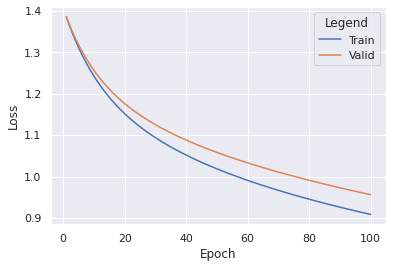

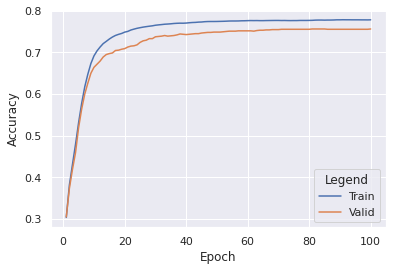

In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score

sns.set()

plot_train_df = pd.DataFrame({
    'Epoch': range(1, 101),
    'Loss': [train_loss.item() for train_loss in train_losses],
    'Accuracy': [train_acc.item() for train_acc in train_accs],
    'Legend': 'Train'
})

plot_valid_df = pd.DataFrame({
    'Epoch': range(1, 101),
    'Loss': [valid_loss.item() for valid_loss in valid_losses],
    'Accuracy': [valid_acc.item() for valid_acc in valid_accs],
    'Legend': 'Valid'
})

data = pd.concat([plot_train_df, plot_valid_df])

# plot losses
ax1 = sns.lineplot(x="Epoch", y="Loss", data=data, hue="Legend")
ax1.set(xlabel="Epoch", ylabel="Loss")
plt.show()

# plot accuracies
ax2 = sns.lineplot(x="Epoch", y="Accuracy", data=data, hue="Legend")
ax2.set(xlabel="Epoch", ylabel="Accuracy")
plt.show()

## 76. チェックポイント

In [ ]:
import pathlib

# mkdir
pathlib.Path('checkpoint').mkdir(exist_ok=True)

# Define new network
torch.manual_seed(46)
single_layer_network = nn.Sequential(
    nn.Linear(300, 4)
)

cross_entropy_loss = nn.CrossEntropyLoss()
optimizer = SGD(single_layer_network.parameters(), lr=0.1)

train_losses, valid_losses = [], []
train_accs, valid_accs = [], []

for epoch in tqdm.tqdm(range(1, 101)):
    optimizer.zero_grad()
    
    # get losses
    logits = single_layer_network(Xs['train'])
    train_losses.append(cross_entropy_loss(logits.squeeze(), ys['train'].squeeze()))
    pred_train = logits.argmax(dim=2).detach()

    logits = single_layer_network(Xs['valid'])
    valid_losses.append(cross_entropy_loss(logits.squeeze(), ys['valid'].squeeze()))
    pred_valid = logits.argmax(dim=2).detach()

    # get accuracies
    train_accs.append(accuracy_score(ys['train'].squeeze(), pred_train.squeeze()))
    valid_accs.append(accuracy_score(ys['valid'].squeeze(), pred_valid.squeeze()))

    # backward
    train_losses[-1].backward()
    optimizer.step()

    # save checkpoint
    torch.save({
        'epoch': epoch,
        'model_state_dict': single_layer_network.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': train_losses[-1],
        }, 'checkpoint/epoch_{:}.pt'.format(epoch))

100%|██████████| 100/100 [00:00<00:00, 117.60it/s]


## 77. ミニバッチ化

In [ ]:
# define DataSet
class DataSet:
    def __init__(self, X, y):
        self.X = X.squeeze()
        self.y = y.squeeze()

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        return {'X': self.X[index], 'y': self.y[index]}

train_dataset = DataSet(Xs['train'], ys['train'])

In [ ]:
import time
from torch.utils.data import DataLoader

cross_entropy_loss = nn.CrossEntropyLoss()

for batch_size in [2**i for i in range(1, 11)]:
    
    # Define new network
    torch.manual_seed(46)
    single_layer_network = nn.Sequential(
        nn.Linear(300, 4)
    )
    train_losses, train_accs = [], []

    optimizer = SGD(single_layer_network.parameters(), lr=0.1)

    # time
    start = time.time()

    dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size)
    for data in dataloader:
        optimizer.zero_grad()
        
        # get losses
        logits = single_layer_network(data['X'])
        train_losses.append(cross_entropy_loss(logits.squeeze(), data['y'].squeeze()))
        pred_train = logits.argmax(dim=1).detach()

        # get accuracies
        train_accs.append(accuracy_score(data['y'].squeeze(), pred_train.squeeze()))

        # backward
        train_losses[-1].backward()
        optimizer.step()

    t = time.time() - start
    print('Time={:.3f}sec. (batch_size={:})'.format(t, batch_size))

    # save checkpoint
    torch.save({
        'epoch': 1,
        'model_state_dict': single_layer_network.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': train_losses[-1],
        }, 'checkpoint/batch_size_{:}.pt'.format(batch_size))

Time=2.607sec. (batch_size=2)
Time=1.298sec. (batch_size=4)
Time=0.673sec. (batch_size=8)
Time=0.360sec. (batch_size=16)
Time=0.201sec. (batch_size=32)
Time=0.129sec. (batch_size=64)
Time=0.106sec. (batch_size=128)
Time=0.073sec. (batch_size=256)
Time=0.059sec. (batch_size=512)
Time=0.051sec. (batch_size=1024)


## 78. GPU上での学習

In [6]:
import time

import torch
import torch.nn as nn
from torch.optim import SGD
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score

from google.colab import files

# define DataSet
class DataSet:
    def __init__(self, X, y):
        self.X = X.squeeze()
        self.y = y.squeeze()

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        return {'X': self.X[index], 'y': self.y[index]}

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print('Using {} device'.format(device.type))

# upload dataset
files.upload()

X = torch.load(
    'X_train.pickle',
    map_location=device)
y = torch.load(
    'y_train.pickle',
    map_location=device)

train_dataset = DataSet(X, y)

cross_entropy_loss = nn.CrossEntropyLoss()

for batch_size in [2**i for i in range(1, 11)]:
    
    # Define new network
    torch.manual_seed(46)
    single_layer_network = nn.Sequential(
        nn.Linear(300, 4)
    )
    single_layer_network.to(device)
    train_losses, train_accs = [], []

    optimizer = SGD(single_layer_network.parameters(), lr=0.1)

    # time
    start = time.time()

    dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size)
    for data in dataloader:
        optimizer.zero_grad()
        
        # get losses
        logits = single_layer_network(data['X'])
        train_losses.append(cross_entropy_loss(logits.squeeze(), data['y'].squeeze()))
        pred_train = logits.argmax(dim=1).detach()

        # get accuracies
        data_y_cpu = data['y'].clone().squeeze().cpu()
        pred_train_cpu = pred_train.clone().squeeze().cpu()
        train_accs.append(accuracy_score(data_y_cpu, pred_train_cpu))

        # backward
        train_losses[-1].backward()
        optimizer.step()

    t = time.time() - start
    print('Time={:.3f}sec. (batch_size={:})'.format(t, batch_size))

    # save checkpoint
    torch.save({
        'epoch': 1,
        'model_state_dict': single_layer_network.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': train_losses[-1],
        }, 'checkpoint/gpu_batch_size_{:}.pt'.format(batch_size))

Using cuda device


Time=7.088sec. (batch_size=2)
Time=3.510sec. (batch_size=4)
Time=1.760sec. (batch_size=8)
Time=0.877sec. (batch_size=16)
Time=0.497sec. (batch_size=32)
Time=0.287sec. (batch_size=64)
Time=0.164sec. (batch_size=128)
Time=0.114sec. (batch_size=256)
Time=0.092sec. (batch_size=512)
Time=0.073sec. (batch_size=1024)


## 79. 多層ニューラルネットワーク

In [12]:
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import SGD
from torch.utils.data import DataLoader
import tqdm
from sklearn.metrics import accuracy_score

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print('Using {} device'.format(device.type))

Using cpu device


In [4]:
# define DataSet
class DataSet:
    def __init__(self, X, y):
        self.X = X.squeeze()
        self.y = y.squeeze()

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        return {'X': self.X[index], 'y': self.y[index]}

# Read files
Xs, ys = {}, {}
for dataset in ['train', 'valid', 'test']:
    Xs[dataset] = torch.load(
        'X_{:}.pickle'.format(dataset),
        map_location=device)
    ys[dataset] = torch.load(
        'y_{:}.pickle'.format(dataset),
        map_location=device)

train_dataset = DataSet(Xs['train'], ys['train'])
valid_dataset = DataSet(Xs['valid'], ys['valid'])
test_dataset = DataSet(Xs['test'], ys['test'])

In [6]:
# define network
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(300, 128)
        self.fc2 = nn.Linear(128, 32)
        self.fc3 = nn.Linear(32, 4)

        self.dropout = nn.Dropout(p=0.2)
    
    def forward(self, x):
        x = x.view(x.shape[0], -1)

        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = F.log_softmax(self.fc3(x), dim=1)

        return x

In [30]:
# Define new network
torch.manual_seed(46)
model = Classifier()
model.to(device)

optimizer = SGD(model.parameters(), lr=0.1)
criterion = nn.NLLLoss()
epochs = 500

train_losses, valid_losses = [], []

for epoch in tqdm.tqdm(range(epochs)):

    trainloader = torch.utils.data.DataLoader(
        train_dataset, batch_size=train_dataset.__len__())

    for data in trainloader:
        optimizer.zero_grad()
        
        # get losses
        logits = model(data['X'])
        train_loss = criterion(logits.squeeze(), data['y'].squeeze())

        # back propagation
        train_loss.backward()
        optimizer.step()

        train_losses.append(train_loss)
    
    # validate
    model.eval()

    validloader = torch.utils.data.DataLoader(
        valid_dataset, batch_size=valid_dataset.__len__())

    for data in validloader:
        # get losses
        logits = model(data['X'])
        valid_loss = criterion(logits.squeeze(), data['y'].squeeze())

        valid_losses.append(valid_loss)
    
    model.train()

100%|██████████| 500/500 [00:46<00:00, 10.79it/s]


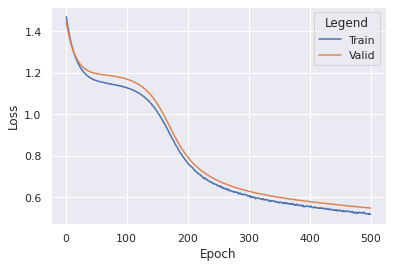

In [31]:
%matplotlib inline

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.metrics import accuracy_score

sns.set()

plot_train_df = pd.DataFrame({
    'Epoch': range(1, epochs+1),
    'Loss': [train_loss.item() for train_loss in train_losses],
    'Legend': 'Train'
})

plot_valid_df = pd.DataFrame({
    'Epoch': range(1, epochs+1),
    'Loss': [valid_loss.item() for valid_loss in valid_losses],
    'Legend': 'Valid'
})

data = pd.concat([plot_train_df, plot_valid_df])

# plot losses
ax1 = sns.lineplot(x="Epoch", y="Loss", data=data, hue="Legend")
ax1.set(xlabel="Epoch", ylabel="Loss")
plt.show()

In [33]:
# test
import numpy as np
model.eval()

testloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=test_dataset.__len__())

accuracies = []

for data in testloader:
    # get losses
    logits = model(data['X'])
    prediction = logits.argmax(dim=1).detach()

    accuracies.append(accuracy_score(data['y'].squeeze(), prediction.squeeze()))

print(np.average(accuracies))

0.8200899550224887
